#IS 675 Lab 4: Tensors: Multidimensional arrays

---

###1. From Python lists to PyTorch tensors
Let’s see list indexing in action so we can compare it to tensor indexing.

In [547]:
# Take a list of three numbers in Python
a = [1.0, 2.0, 1.0]

In [548]:
# Access the first element of the list using the corresponding zero-based index
a[0]

1.0

In [549]:
# Access and update third element
a[2] = 3.0
a

[1.0, 2.0, 3.0]

###2. Constructing our first tensors
Let’s construct our first PyTorch tensor and see what it looks like. It won’t be a particularly meaningful tensor for now, just three ones in a column; although on the surface this example doesn’t differ much from a list of number objects, under the hood things are completely different.

In [550]:
# Import the torch module and creat a one dimensional tensor of three ones
import torch # <1>
a = torch.ones(3) # <2>
a

tensor([1., 1., 1.])

In [551]:
# Access the second element
a[1]

tensor(1.)

In [552]:
# Access the second element's value
float(a[1])

1.0

In [553]:
# Update the third element
a[2] = 2.0
a

tensor([1., 1., 2.])

###3. The essence of tensors
Python lists or tuples of numbers are collections of Python objects that are individually allocated in memory, as shown on the left in figure below. PyTorch tensors or NumPy arrays, on the other hand, are views over (typically) contiguous memory blocks containing unboxed C numeric types rather than Python objects. Each element is a 32-bit (4-byte) float in this case, as we can see on the right side of figure below. This means storing a 1D tensor of 1,000,000 float numbers will require exactly 4,000,000 contiguous bytes, plus a small overhead for the metadata (such as dimensions and numeric type).

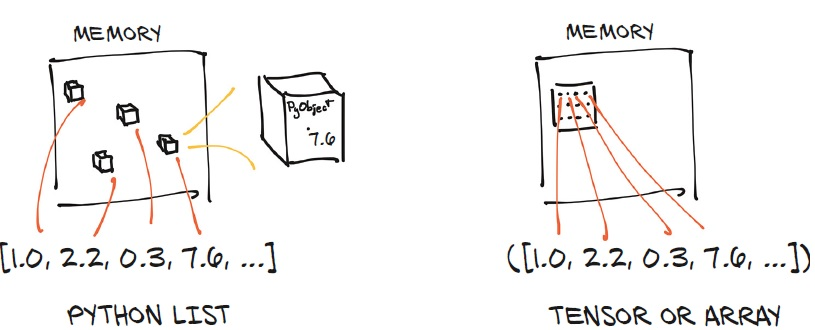

We’d like to represent a geometrical object:
perhaps a 2D triangle with vertices at coordinates (4, 1), (5, 3), and (2, 1). The example is not particularly pertinent to deep learning, but it’s easy to follow.

In [554]:
# Using .zeros to get an appropriately sized array, then overwrite it with the given coordinates
points = torch.zeros(6) # <1>
points[0] = 4.0 # <2>
points[1] = 1.0
points[2] = 5.0
points[3] = 3.0
points[4] = 2.0
points[5] = 1.0
points

tensor([4., 1., 5., 3., 2., 1.])

In [555]:
# Pass a Python list to the constructor
points = torch.tensor([4.0, 1.0, 5.0, 3.0, 2.0, 1.0])
points

tensor([4., 1., 5., 3., 2., 1.])

In [556]:
# Get the coordinates of the first point
float(points[0]), float(points[1])

(4.0, 1.0)

In [557]:
# Pass a list of lists to the constructor
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [558]:
# Get the tensor shape
points.shape

torch.Size([3, 2])

In [559]:
# use zeros or ones to initialize the tensor
points = torch.zeros(3, 2)
points

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [560]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [561]:
# Access an element in the tensor using two indices
points[0, 1]

tensor(1.)

In [562]:
# Access the first element in the tensor
points[0]

tensor([4., 1.])

Does this mean a new chunk of memory was allocated, values were copied
into it, and the new memory was returned wrapped in a new tensor object? No, because that would be very inefficient, especially if we had millions of points.

### 4.Tensors: Scenic views of storage

Values in tensors are allocated in contiguous chunks of memory managed by torch.Storage instances. A storage is a one-dimensional array of numerical data: that is, a contiguous block of memory containing numbers of a given type, such as float (32 bits representing a floating-point number) or int64 (64 bits representing an integer). A PyTorch Tensor instance is a view of such a Storage instance that is capable of indexing into that storage using an offset and per-dimension strides.
Multiple tensors can index the same storage even if they index into the data differently. (see figure below)

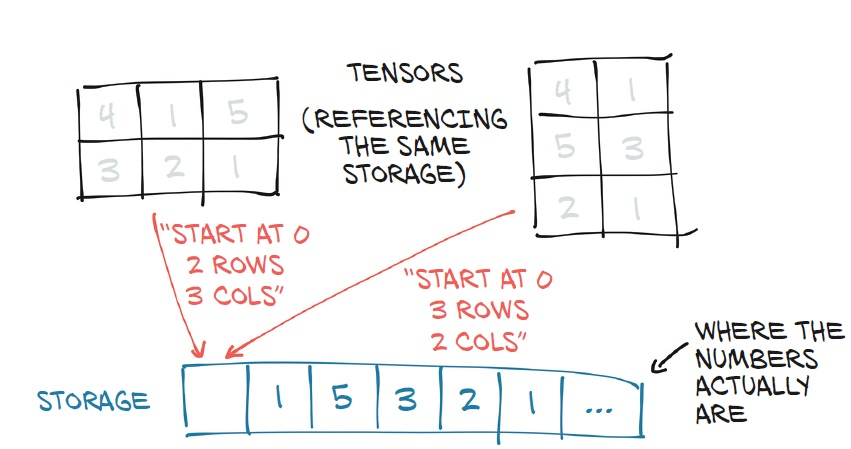

In [563]:
# Access the storage for a given tensor
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points.storage()

 4.0
 1.0
 5.0
 3.0
 2.0
 1.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 6]

In [564]:
# Index into a storage manually
points_storage = points.storage()
points_storage[0]

4.0

We can’t index a storage of a 2D tensor using two indices. The layout of a storage is always one-dimensional, regardless of the dimensionality of any and all tensors that might refer to it.

Also, changing the value of a storage leads to changing the content of its referring tensor:

In [565]:
# Change the value of a storage
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points_storage = points.storage()
points_storage[0] = 2.0
points

tensor([[2., 1.],
        [5., 3.],
        [2., 1.]])

###5. Tensor metadata: Size, offset, and stride
In order to index into a storage, tensors rely on a few pieces of information that, together with their storage, unequivocally define them: size, offset, and stride.

**size** or shape: is a tuple indicating how many elements across each dimension the tensor represents.

**offset**: is the index in the storage corresponding to the first element in the tensor.

**stride**: is the number of elements in the storage that need to be skipped over to obtain the next element along each dimension.

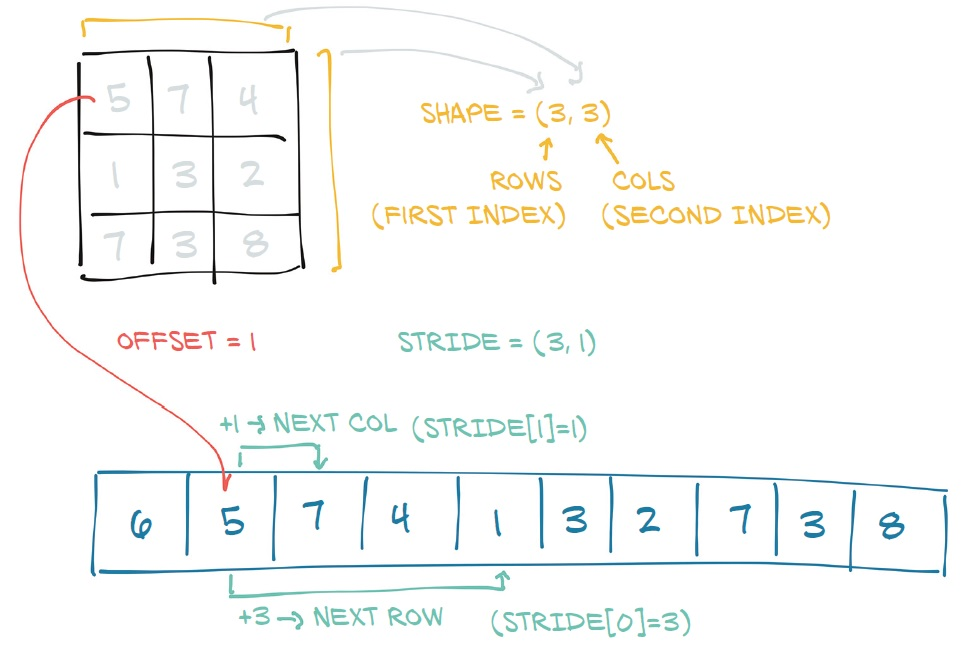

In [566]:
# Offset
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1]
second_point.storage_offset()

2

In [567]:
# Size or shape
second_point.size()

torch.Size([2])

In [568]:
# Size or shape
second_point.shape

torch.Size([2])

In [569]:
# Stride
second_point.stride()

(1,)

In [570]:
# Stride of points
points.stride()

(2, 1)

Accessing an element i, j in a 2D tensor results in accessing the storage_offset + stride[0] * i + stride[1] * j element in the storage. This indirection between Tensor and Storage makes some operations inexpensive,
like transposing a tensor or extracting a subtensor.

Q1. why does the indirection between Tensor and Storage makes some operations inexpensive? (1 pts)

**Answer**: The indirection between Tensor and Storage`makes operations like transposing or extracting a subtensor inexpensive because the tensor just changes how it references the data (adjusting strides or offsets) without copying or moving the underlying data in memory.

Q2. Given a tensor, how the transpose or a subtensor is allocated in the memory? (1 pts)

**Answer:** Transpose and subtensor operations reuse the same memory by adjusting strides and offsets, without copying data.


Q3. Does changing a subtensor impact the original tensor? answer by testing an example in the following code cell. (1 pts)

**Answer:** Yes, modifying a subtensor affects the original tensor because they both share the same memory.

In [571]:
# Q3
original_tensor = torch.tensor([[1, 2, 3],
                                [4, 5, 6],
                                [7, 8, 9]])

sub_tensor = original_tensor[:2, :2]

sub_tensor[0, 0] = 99

print("Original Tensor:\n", original_tensor)
print("\nSubtensor:\n", sub_tensor)

Original Tensor:
 tensor([[99,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]])

Subtensor:
 tensor([[99,  2],
        [ 4,  5]])


Q4. What is the stride for a tensor in 3D with a 3*2 array in each dimension? what if we have 2 by 3 arrays in each dimension? Give an exmaple in the cell below. (1 pts)

**Answer:**

In [572]:
# Q4

tensor_3x3x2 = torch.randn(3, 3, 2)
print("Tensor (3, 3, 2) strides:", tensor_3x3x2.stride())

tensor_3x2x3 = torch.randn(3, 2, 3)
print("Tensor (3, 2, 3) strides:", tensor_3x2x3.stride())

Tensor (3, 3, 2) strides: (6, 2, 1)
Tensor (3, 2, 3) strides: (6, 3, 1)


In [573]:
# Clone the subtensor into a new tensor to create a completely independent copy of the subtensor
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1].clone()
second_point[0] = 10.0
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

###6. Transposing without copying

In [574]:
# Create a 2D tensor
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [575]:
# Transpose the tensor
points_t = points.t()
points_t

tensor([[4., 5., 2.],
        [1., 3., 1.]])

The two tensors share the same storage and they differ only in shape and stride:

In [576]:
# Two tensors share the same storage
points_t[0,0] = 10
points

tensor([[10.,  1.],
        [ 5.,  3.],
        [ 2.,  1.]])

In [577]:
# Two have different strides
points.stride()

(2, 1)

In [578]:
# Two have different strides
points_t.stride()

(1, 2)

In [579]:
# Transpose in higher dimensions
some_t = torch.ones(3, 4, 5)
transpose_t = some_t.transpose(0, 2)
some_t.shape

torch.Size([3, 4, 5])

In [580]:
# Shape of transpose in higher dimensions
transpose_t.shape

torch.Size([5, 4, 3])

###7. Contiguous tensors
Some tensor operations in PyTorch only work on contiguous tensors, such as view.
In our example points is contiguous, while its transpose is not!!

In [581]:
# Remember our points and its transpose
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points_t = points.t()
points_t

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [582]:
# Both tensors share the same storage
points_t.storage()

 4.0
 1.0
 5.0
 3.0
 2.0
 1.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 6]

In [583]:
# But transpose is not contiguous
points_t.stride()

(1, 2)

In [584]:
# Make a tensor contiguous
points_t_cont = points_t.contiguous()
points_t_cont

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [585]:
# Check the stride for the new tensor
points_t_cont.stride()

(3, 1)

In [586]:
# Check the storage for the new tensor
points_t_cont.storage()

 4.0
 5.0
 2.0
 1.0
 3.0
 1.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 6]

###8. Moving tensors to the GPU

In [587]:
# Create a tensor on the GPU by specifying the corresponding argument to the constructor
points_gpu = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]], device='cuda')

In [588]:
# copy a tensor created on the CPU onto the GPU using the to method
points_gpu = points.to(device='cuda')

###9. Saving the tensor

In [589]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [590]:
# Save the tensor
torch.save(points, '/content/drive/MyDrive/IS675_data/ourpoints.t')

In [591]:
# Load the tensor
points = torch.load('/content/drive/MyDrive/IS675_data/ourpoints.t')
points

<ipython-input-591-63d2483c3f22>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  points = torch.load('/content/drive/MyDrive/IS675_data/ourpoints.t')


tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

Q5. Create a tensor a from list(range(9)). Predict and then check the size, offset, and stride. (1 pts)

In [592]:
# Q5

a = torch.tensor(list(range(9)))

print("Size:", a.size())
print("Storage Offset:", a.storage_offset())
print("Stride:", a.stride())

Size: torch.Size([9])
Storage Offset: 0
Stride: (1,)



Q6. Create a new tensor using b = a.view(3, 3). What does view do? Check
that a and b share the same storage. (1 pts)

In [593]:
# Q6

a = torch.tensor(list(range(9)))
b = a.view(3, 3)
print(a.storage().data_ptr() == b.storage().data_ptr())

True


Q7. Create a tensor c = b[1:,1:]. Predict and then check the size, offset, and
stride. Does c share the same storage? (1 pts)

In [594]:
# Q7

c = b[1:, 1:]

In [595]:
c.size(), c.storage(), c.stride()

(torch.Size([2, 2]),
  0
  1
  2
  3
  4
  5
  6
  7
  8
 [torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 9],
 (3, 1))

In [596]:
print(b.storage().data_ptr() == c.storage().data_ptr())

True


In [597]:
c.size(), c.storage(), c.stride()

(torch.Size([2, 2]),
  0
  1
  2
  3
  4
  5
  6
  7
  8
 [torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 9],
 (3, 1))

In [598]:
print(b.storage().data_ptr() == c.storage().data_ptr())

True


In [599]:
!jupyter nbconvert --to html "/content/drive/My Drive/Colab Notebooks/IS675_lab04.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/IS675_lab04.ipynb to html
[NbConvertApp] Writing 959179 bytes to /content/drive/My Drive/Colab Notebooks/IS675_lab04.html
